In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../..")

import pandas as pd
import seaborn as sns
from plot_config import savefig

from xlstm_scaling_laws.analysis.parametric_sclaw_fit.run_fit_grid import (
    load_combined_fit_grid_df,
)
from xlstm_scaling_laws.analysis.plot_lnd_pareto_combined import (
    plot_lnd_pareto_combined,
)

While loading IsoFLOP Runs: Overriding attention flop calc mode to distill_scaling.
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_80M_ctx2048_lr0.003_steps16400_nb10_ed512_nh4_pf2.667_gbs512, id=0m5bmumq, path=['xlstm', 'xlstm_jax', '0m5bmumq'], created_at=2025-04-13T06:17:04Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_200M_ctx2048_lr0.003_steps3000_nb27_ed896_nh7_pf2.667_gbs512, id=ch1anxyv, path=['xlstm', 'xlstm_jax', 'ch1anxyv'], created_at=2025-04-13T17:35:13Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_80M_ctx2048_lr0.003_steps27200_nb10_ed512_nh4_pf2.667_gbs512, id=52pij92y, path=['xlstm', 'xlstm_jax', '52pij92y'], created_at=2025-04-13T08:12:40Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_500M_ctx2048_lr0.002_steps9600_nb27_ed1152_nh9_pf2.667_gbs512, id=oyn1hwkt, path=['xlstm', 'xlstm_jax', 'oyn1hwkt'], created_at=2025-04-14T17:41:

# Compare mLSTM vs. Llama: Pareto-Frontier

In [2]:
data_dir_lnd_fits = "../../data_lnd_fits"

/home/max/myrepos/nxai_public/mlstm_scaling_laws/notebooks/paper_plots/../../xlstm_scaling_laws/analysis/parametric_sclaw_fit/plot/plot_scaling_law_fit_single.py:86: PerformanceWarning: indexing past lexsort depth may impact performance.
  model_tag_fit_df = combined_fit_grid_df.loc[
/home/max/myrepos/nxai_public/mlstm_scaling_laws/notebooks/paper_plots/../../xlstm_scaling_laws/analysis/parametric_sclaw_fit/plot/plot_scaling_law_fit_single.py:86: PerformanceWarning: indexing past lexsort depth may impact performance.
  model_tag_fit_df = combined_fit_grid_df.loc[


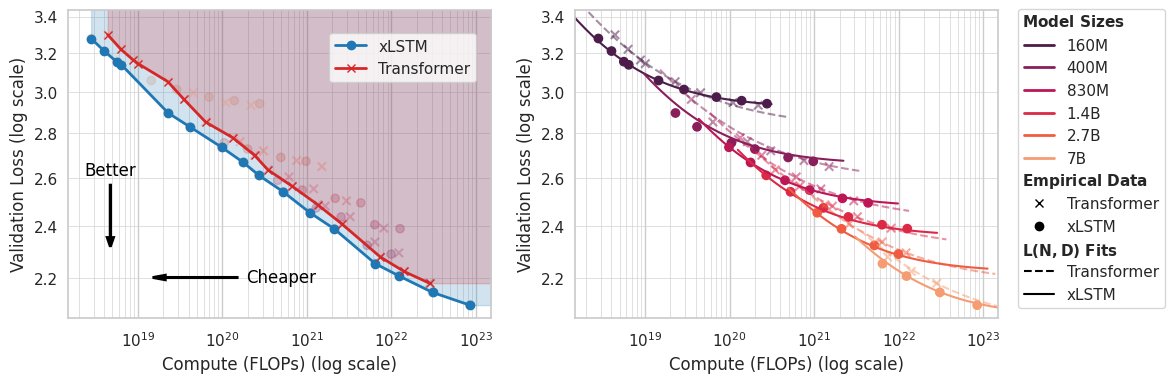

In [3]:
df = load_combined_fit_grid_df(
    save_dir=data_dir_lnd_fits,
    use_logsumexp=True,
    huber_delta=1e-3,  # 1e-3, #1e-5, #5.0,#1e-5,#5.0,
    fit_gamma=True,  # True, False
    context_length=8192,
).sort_values(by=("val_results", "tokenparam#mse"))

with sns.plotting_context("notebook", font_scale=1.0):
    with sns.axes_style("whitegrid"):
        fig = plot_lnd_pareto_combined(
            figsize=(12, 4),
            combined_fit_grid_df=df,
            experiment_set_fit="tokenparam",  # "all", "tokenparam", "isoflop"
            experiment_set_plot_data_points="tokenparam",
            x_axis_mode="num_flops",
        )

In [4]:
savefig(fig, filename="lnd_pareto_combined_llama_mlstm")

In [5]:
def get_fit_params_by_huber_delta(data_dir_lnd_fits, huber_deltas=None):
    """
    Extract optimal fit parameters for different huber delta values.

    Parameters:
    -----------
    data_dir_lnd_fits : str
        Directory containing the fit data
    huber_deltas : list, optional
        List of huber delta values to test. If None, uses default values.

    Returns:
    --------
    pd.DataFrame
        DataFrame with MultiIndex where first level is huber_delta,
        second level is model type (Transformer, xLSTM), and columns are fit parameters
    """
    import pandas as pd

    from xlstm_scaling_laws.analysis.parametric_sclaw_fit.run_fit_grid import (
        load_combined_fit_grid_df,
    )

    if huber_deltas is None:
        # huber_deltas = [1e-5, 1e-3, 1e-2, 1e-1, 1.0, 5.0, 10.0]
        huber_deltas = [1e-5, 1e-3, 1e-1, 1.0, 10.0]

    all_results = []

    for huber_delta in huber_deltas:
        df = load_combined_fit_grid_df(
            save_dir=data_dir_lnd_fits,
            use_logsumexp=True,
            huber_delta=huber_delta,
            fit_gamma=True,
            context_length=8192,
        ).sort_values(by=("val_results", "tokenparam#mse"))

        # Extract parameters for Transformer (llama)
        model_tag = "llama"
        experiment_set_fit = "tokenparam"
        token_param_range = "0-5000"
        opt_params_llama = df.loc[
            model_tag, experiment_set_fit, token_param_range
        ].iloc[0, :]["optim_params"]

        # Extract parameters for xLSTM (mlstm)
        model_tag = "mlstm"
        experiment_set_fit = "tokenparam"
        token_param_range = "0-5000"
        opt_params_mlstm = df.loc[
            model_tag, experiment_set_fit, token_param_range
        ].iloc[0, :]["optim_params"]

        # Create temporary DataFrame for this huber_delta
        temp_df = pd.concat(
            [
                pd.Series(opt_params_llama, name="Transformer"),
                pd.Series(opt_params_mlstm, name="xLSTM"),
            ],
            axis=1,
        ).T

        # Add huber_delta as index level
        temp_df.index = pd.MultiIndex.from_product(
            [[huber_delta], temp_df.index], names=["huber_delta", "model"]
        )

        all_results.append(temp_df)

    # Combine all results
    result_df = pd.concat(all_results, axis=0)
    result_df = result_df.swaplevel().sort_index()
    return result_df

In [6]:
huber_df = get_fit_params_by_huber_delta(data_dir_lnd_fits)
# huber_df.swaplevel().sort_index().style
huber_df.style

/tmp/ipykernel_254786/1265804788.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  opt_params_llama = df.loc[model_tag, experiment_set_fit, token_param_range].iloc[0, :]["optim_params"]
/tmp/ipykernel_254786/1265804788.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  opt_params_mlstm = df.loc[model_tag, experiment_set_fit, token_param_range].iloc[0, :]["optim_params"]
/tmp/ipykernel_254786/1265804788.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  opt_params_llama = df.loc[model_tag, experiment_set_fit, token_param_range].iloc[0, :]["optim_params"]
/tmp/ipykernel_254786/1265804788.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  opt_params_mlstm = df.loc[model_tag, experiment_set_fit, token_param_range].iloc[0, :]["optim_params"]
/tmp/ipykernel_254786/1265804788.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  opt_params_llama =

In [7]:
print(
    huber_df.to_latex(
        float_format="%.2f",
        caption="Optimal fit parameters for the L(N,D) model for Transformer and xLSTM models.",
        label="tab:lnd_fit_params",
        index=True,
        header=True,
        # escape=False,
    )
)

\begin{table}
\caption{Optimal fit parameters for the L(N,D) model for Transformer and xLSTM models.}
\label{tab:lnd_fit_params}
\begin{tabular}{llllllll}
\toprule
 &  & a & b & e & alpha & beta & gamma \\
model & huber_delta &  &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{Transformer} & 0.000010 & 12.96 & 14.35 & 0.05 & 0.58 & 0.55 & 0.28 \\
 & 0.001000 & 11.99 & 13.35 & 0.01 & 0.53 & 0.51 & 0.29 \\
 & 0.100000 & 14.44 & 16.33 & 0.09 & 0.64 & 0.63 & 0.25 \\
 & 1.000000 & 14.45 & 16.33 & 0.09 & 0.64 & 0.63 & 0.25 \\
 & 10.000000 & 14.45 & 16.33 & 0.09 & 0.64 & 0.63 & 0.25 \\
\cline{1-8}
\multirow[t]{5}{*}{xLSTM} & 0.000010 & 16.13 & 17.10 & 0.07 & 0.71 & 0.66 & 0.24 \\
 & 0.001000 & 16.22 & 17.31 & 0.11 & 0.73 & 0.67 & 0.24 \\
 & 0.100000 & 15.46 & 16.53 & 0.18 & 0.71 & 0.65 & 0.26 \\
 & 1.000000 & 15.46 & 16.53 & 0.18 & 0.71 & 0.65 & 0.26 \\
 & 10.000000 & 15.46 & 16.53 & 0.18 & 0.71 & 0.65 & 0.26 \\
\cline{1-8}
\bottomrule
\end{tabular}
\end{table}



In [8]:
# Make a table with the fit params for the L(N,D) model
# Note: there are many fits for each model, here we just take the best one (lowest mse)

df = load_combined_fit_grid_df(
    save_dir=data_dir_lnd_fits,
    use_logsumexp=True,
    huber_delta=1.0,  # 1e-3,#1e-3, #1e-5, #5.0,#1e-5,#5.0,
    fit_gamma=True,  # True, False
    context_length=8192,
).sort_values(by=("val_results", "tokenparam#mse"))
model_tag = "llama"
experiment_set_fit = "tokenparam"
token_param_range = "0-5000"
opt_params_llama = df.loc[model_tag, experiment_set_fit, token_param_range].iloc[0, :][
    "optim_params"
]  # the fits are sorted by mse (fit quality, best first)
model_tag = "mlstm"
experiment_set_fit = "tokenparam"
token_param_range = "0-5000"
opt_params_mlstm = df.loc[model_tag, experiment_set_fit, token_param_range].iloc[0, :][
    "optim_params"
]
opt_params = pd.concat(
    [
        pd.Series(opt_params_llama, name="Transformer"),
        pd.Series(opt_params_mlstm, name="xLSTM"),
    ],
    axis=1,
)

/tmp/ipykernel_254786/645915022.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  opt_params_llama = df.loc[model_tag, experiment_set_fit, token_param_range].iloc[0, :]["optim_params"] # the fits are sorted by mse (fit quality, best first)
/tmp/ipykernel_254786/645915022.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  opt_params_mlstm = df.loc[model_tag, experiment_set_fit, token_param_range].iloc[0, :]["optim_params"]


In [9]:
opt_params.T

,a,b,e,alpha,beta,gamma
Transformer,14.445072,16.329536,0.090102,0.644827,0.625879,0.253203
xLSTM,15.457385,16.52583,0.176768,0.705822,0.653441,0.2578


In [10]:
print(
    opt_params.T.to_latex(
        float_format="%.2f",
        caption="Optimal fit parameters for the L(N,D) model for Transformer and xLSTM models.",
        label="tab:lnd_fit_params",
        index=True,
        header=True,
        escape=False,
    )
)

\begin{table}
\caption{Optimal fit parameters for the L(N,D) model for Transformer and xLSTM models.}
\label{tab:lnd_fit_params}
\begin{tabular}{lllllll}
\toprule
 & a & b & e & alpha & beta & gamma \\
\midrule
Transformer & 14.45 & 16.33 & 0.09 & 0.64 & 0.63 & 0.25 \\
xLSTM & 15.46 & 16.53 & 0.18 & 0.71 & 0.65 & 0.26 \\
\bottomrule
\end{tabular}
\end{table}

